In [1]:
import os
import sys

import librosa
import psycopg2
import numpy as np
import pandas as pd
import librosa.display
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from psycopg2.extras import DictCursor

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scripts.fetch_data import fetch_coughs_from_db

load_dotenv()

DB_CREDENTIALS = {
    'user': os.environ['PGUSER'],
    'password': os.environ['PGPASSWORD'],
    'host': os.environ['PGHOST'],
    'database': os.environ['PGDATABASE']
}

## Preprocessing

In [12]:
def get_row(data):
    return {
        "filename": data["filename"],
        "coughing": "coughing" in data["questions"]["symptoms"],
        "fatigue": "fatigue" in data["questions"]["symptoms"],
        "digestive_issues": "digestive_issues" in data["questions"]["symptoms"],
        "body_ache_chills": "body_ache_chills" in data["questions"]["symptoms"],
        "headache": "headache" in data["questions"]["symptoms"],
        "congestion": "congestion" in data["questions"]["symptoms"],
        "shortness_of_breath": "shortness_of_breath" in data["questions"]["symptoms"],
        "fever": "fever" in data["questions"]["symptoms"],
        "positive": data["questions"]["diagnosis"] == "tested_positive_present"
    }

In [20]:
BASE_PATH = "../data"

with psycopg2.connect(**DB_CREDENTIALS, cursor_factory=DictCursor) as conn:
    coughs = fetch_coughs_from_db(conn)

df = []
for c in coughs:
    f = f"{BASE_PATH}/{c['filename']}"

    # NOTE: hackily check if we have segments
    for i in range(1, 10):
        curr = f"{f.replace('.wav', '')}_cut00{i}.wav"
        if os.path.isfile(curr):
            c['filename'] = curr
            df.append(get_row(c))

df = pd.DataFrame(df)
df.head()

,filename,coughing,fatigue,digestive_issues,body_ache_chills,headache,congestion,shortness_of_breath,fever,positive
0,../data/coughs/be470bc1-959c-4653-a44e-b4b88cd...,False,False,False,False,False,False,False,False,False
1,../data/coughs/be470bc1-959c-4653-a44e-b4b88cd...,False,False,False,False,False,False,False,False,False
2,../data/coughs/be470bc1-959c-4653-a44e-b4b88cd...,False,False,False,False,False,False,False,False,False
3,../data/coughs/b38b64ff-871f-487c-b126-d6f6500...,False,False,False,False,False,False,False,False,False
4,../data/coughs/b38b64ff-871f-487c-b126-d6f6500...,False,False,False,False,False,False,False,False,False


In [21]:
print("Samples")
print(f"Positive: {len(df[df.positive==True])}")
print(f"Negative: {len(df[df.positive==False])}")

Samples
Positive: 61
Negative: 1190


Positive sample: ../data/coughs/9ae8463a-ed46-47ef-b7b7-97ae4016f0f2_cut001.wav


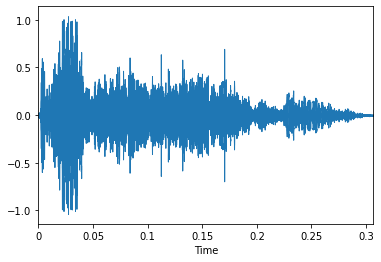

Negative sample: ../data/coughs/be470bc1-959c-4653-a44e-b4b88cd1103e_cut001.wav


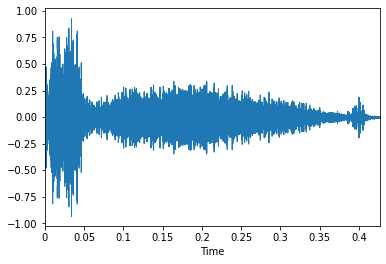

In [35]:
pos = df[df.positive==True].iloc[0]
neg = df[df.positive==False].iloc[0]

print(f"Positive sample: {pos.filename}")
yp, srp = librosa.load(f"{pos.filename}")
librosa.display.waveplot(yp, sr=srp)
plt.show()

print(f"Negative sample: {neg.filename}")
yn, srn = librosa.load(f"{neg.filename}")
librosa.display.waveplot(yn, sr=srn)
plt.show()

/Users/alessandromarin/Documents/projects/covid-19-classifier/venv/lib/python3.7/site-packages/librosa/core/spectrum.py:1702: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


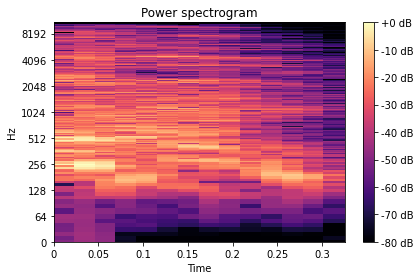

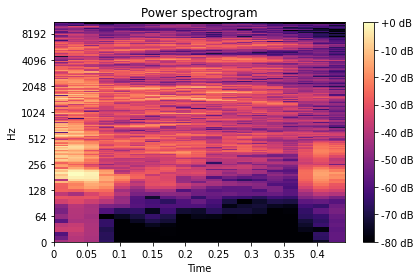

In [37]:
def plot_spec(x):
    x_stft = librosa.stft(x)
    librosa.display.specshow(librosa.amplitude_to_db(x_stft, ref=np.max), y_axis='log', x_axis='time')
    plt.title('Power spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()
    
plot_spec(yp)
plot_spec(yn)